In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
from pathlib import Path
from matplotlib import colors
import zipfile

# SWESAR
* https://snowex-hackweek.github.io/website/tutorials/sar/swesarr.html

In [13]:
import os

os.chdir("../")

In [3]:
from omegaconf import OmegaConf
from metaearth.api import extract_assets
from metaearth.config import ConfigSchema

cfg = OmegaConf.load("config/nsidc.yaml")
cfg_schema = OmegaConf.structured(ConfigSchema)
cfg = OmegaConf.merge(cfg_schema, cfg)

# Constrain the test to only pull one item
for pvdr in cfg.providers:
    for coll in pvdr.collections:
        coll.max_items = 1

print(OmegaConf.to_yaml(cfg))
success = extract_assets(cfg)


print("Successfully extracted assets." if success else "Asset extraction failed.")

/shared/cjrd/miniconda3/envs/me/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
06:37:05 INFO - Extraction details for provider ProviderKey.EARTHDATA with collection ASO_50M_SD: 
id: SNEX20_SWESARR_TB
assets:
- all
outdir: null
datetime: null
aoi_file: null
max_items: 1

06:37:05 INFO - Extraction details for provider ProviderKey.EARTHDATA with collection ASO_50M_SWE: 
id: SNEX20_SWESARR_TB
assets:
- all
outdir: null
datetime: null
aoi_file: null
max_items: 1

06:37:05 INFO - Extraction details for provider ProviderKey.EARTHDATA with collection SNEX20_SWESARR_TB: 
id: SNEX20_SWESARR_TB
assets:
- all
outdir: null
datetime: null
aoi_file: null
max_items: 1



default_collection:
  id: null
  assets: null
  outdir: data
  datetime: 2012-02-10/2022-02-12
  aoi_file: config/aoi/conus-expanded.json
  max_items: -1
providers:
- id: EARTHDATA
  kwargs:
    subprovider_id: NSIDC_ECS
  collections:
  - id: ASO_50M_SD
    assets:
    - all
    outdir: null
    datetime: null
    aoi_file: null
    max_items: 1
  - id: ASO_50M_SWE
    assets:
    - all
    outdir: null
    datetime: null
    aoi_file: null
    max_items: 1
  - id: SNEX20_SWESARR_TB
    assets:
    - all
    outdir: null
    datetime: null
    aoi_file: null
    max_items: 1
system:
  log_outdir: ./logs
  log_level: INFO
  dry_run: false
  max_concurrent_extractions: 5
  max_download_attempts: 3
  remove_existing_if_wrong_size: true
  query_asset_sizes: false
run_id: ''



06:37:07 INFO - EarthData Provider returned 1 items for ASO_50M_SD for datetime 2012-02-10/2022-02-12
06:37:07 INFO - EarthData Provider returned 1 items for ASO_50M_SWE for datetime 2012-02-10/2022-02-12
06:37:08 INFO - EarthData Provider returned 1 items for SNEX20_SWESARR_TB for datetime 2012-02-10/2022-02-12
06:37:08 INFO - 6 assets have unknown file size
06:37:08 INFO - 

****************************************************************************************************
To Extract:
EarthData Provider: ASO_50M_SD.v1
EarthData Provider: ASO_50M_SWE.v1
EarthData Provider: SNEX20_SWESARR_TB.v1


Collection               | Key                 | Description
--------------------------------------------------------------------------------
ASO_50M_SD.v1            | data                | 
ASO_50M_SD.v1            | metadata            | 
ASO_50M_SWE.v1           | data                | 
ASO_50M_SWE.v1           | metadata            | 
SNEX20_SWESARR_TB.v1     | data                | 
SNE

Successfully extracted assets.


In [15]:
fpath = "data/SNEX20_SWESARR_TB/"
print(fpath)

files = glob.glob(fpath + "*")
file = files[0]

data/SNEX20_SWESARR_TB/


In [17]:
datafiles = glob.glob(file + "/*.csv")[0]
data = pd.read_csv(datafiles)
lon = data["Longitude (deg)"]
lat = data["Latitude (deg)"]
print(data)

                           UTC  Longitude (deg)  Latitude (deg)  \
0     20200212-19:38:20.499680      -108.223946       39.035881   
1     20200212-19:38:20.599700      -108.223946       39.035789   
2     20200212-19:38:20.699700      -108.223853       39.035789   
3     20200212-19:38:20.799700      -108.223760       39.035696   
4     20200212-19:38:20.899700      -108.223668       39.035696   
...                        ...              ...             ...   
1343  20200212-19:40:34.903220      -108.115422       39.028288   
1344  20200212-19:40:35.003240      -108.115329       39.028288   
1345  20200212-19:40:35.103240      -108.115237       39.028288   
1346  20200212-19:40:35.203240      -108.115144       39.028288   
1347  20200212-19:40:35.303240      -108.115052       39.028288   

      Elevation (m)  TB X (K)  TB K (K)  TB Ka (K)  Antenna Longitude (deg)  \
0              2925     268.7     271.9      258.5              -108.222414   
1              2929     268.1     269

## Elevation Plot

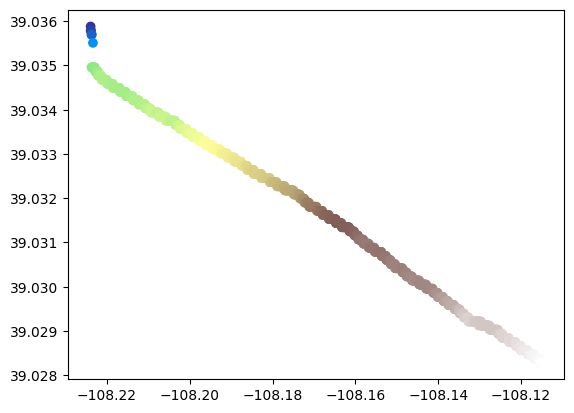

In [18]:
norm = colors.Normalize(vmin=2900, vmax=3200)
cmap = plt.get_cmap("terrain")
elevation = data["Elevation (m)"].values
plt.scatter(data["Longitude (deg)"], data["Latitude (deg)"], c=elevation, cmap=cmap)
plt.show()

## Radiometer plot

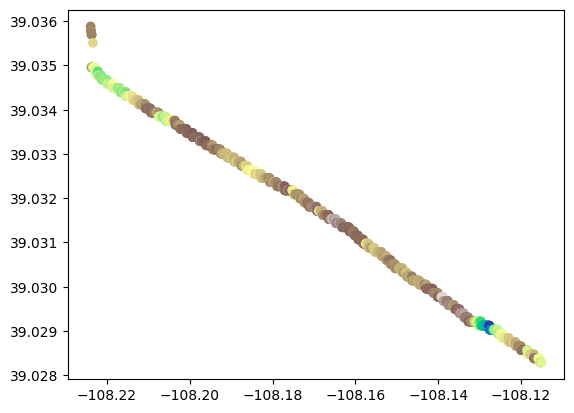

In [19]:
tb_ser = pd.Series(
    data["TB X (K)"].to_list()
    + data["TB K (K)"].to_list()
    + data["TB Ka (K)"].to_list(),
    name="Tb",
)
data["tb"] = tb_ser
plt.scatter(
    data["Longitude (deg)"], data["Latitude (deg)"], c=data["tb"].values, cmap=cmap
)
plt.show()

# UAVSAR
*  https://snowex-hackweek.github.io/website/tutorials/sar/uavsar.html#opening-and-plotting-the-raw-uavsar-raster-files

In [20]:
import rasterio as rio
from rasterio.plot import show  # plotting raster data
from rasterio.plot import show_hist  # histograms of raster data

In [22]:
if False:
    cfg = OmegaConf.load("config/UAVSAR.yaml")
    cfg_schema = OmegaConf.structured(ConfigSchema)
    cfg = OmegaConf.merge(cfg_schema, cfg)

    # Constrain the test to only pull one item
    for pvdr in cfg.providers:
        for coll in pvdr.collections:
            coll.max_items = 1

    successfully_extracted_assets, failed_assets = extract_assets(cfg)
    print(
        f"Successfully extracted {len(successfully_extracted_assets)} assets. {len(failed_assets)} failed."
    )

06:40:15 INFO - Extraction details for provider ProviderKey.EARTHDATA with collection UAVSAR_INSAR_INT_GRD: 
id: UAVSAR_INSAR_AMP_GRD
assets:
- data
- metadata
outdir: null
datetime: null
aoi_file: null
max_items: 1

06:40:15 INFO - Extraction details for provider ProviderKey.EARTHDATA with collection UAVSAR_INSAR_AMP_GRD: 
id: UAVSAR_INSAR_AMP_GRD
assets:
- data
- metadata
outdir: null
datetime: null
aoi_file: null
max_items: 1

06:40:16 INFO - EarthData Provider returned 1 items for UAVSAR_INSAR_INT_GRD for datetime 2021-03-10/2021-03-21
06:40:17 INFO - EarthData Provider returned 1 items for UAVSAR_INSAR_AMP_GRD for datetime 2021-03-10/2021-03-21
06:40:17 INFO - 4 assets did not specify file size, will query size directly with http request (this may take a few moments)
system.query_asset_sizes=False can be used to disable this behavior
100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
06:40:20 INFO - 2 assets have unknown file size
06:40:20 INFO - Removing data/UAVSAR_INSAR_INT_GRD/UA_e

TypeError: cannot unpack non-iterable bool object

## Post process and plot

Following code cells are used to unzip the data, transform to tiff file and plot. GDAL is required to transform the file. 

In [10]:
if False:
    # folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)
    import codecs
    import re

    def uavsar_tiff_convert(folder):
        """
        Builds a header file for the input UAVSAR .grd file,
        allowing the data to be read as a raster dataset.
        :param folder:   the folder containing the UAVSAR .grd and .ann files
        """

        os.chdir(folder)
        int_file = glob.glob(os.path.join(folder, "int.grd"))

        # Empty lists to put information that will be recalled later.
        Lines_list = []
        Samples_list = []
        Latitude_list = []
        Longitude_list = []
        Files_list = []

        # Step 1: Look through folder and determine how many different flights there are
        # by looking at the HDR files.
        for files in os.listdir(folder):
            if files[-4:] == ".grd":
                newfile = open(files[0:-4] + ".hdr", "w")
                newfile.write(
                    """ENVI
    description = {DESCFIELD}
    samples = NSAMP
    lines = NLINE
    bands = 1
    header offset = 0
    data type = DATTYPE
    interleave = bsq
    sensor type = UAVSAR L-Band
    byte order = 0
    map info = {Geographic Lat/Lon, 
                1.000, 
                1.000, 
                LON, 
                LAT,  
                0.0000555600000000, 
                0.0000555600000000, 
                WGS-84, units=Degrees}
    wavelength units = Unknown
                    """
                )
                newfile.close()
                if files[0:18] not in Files_list:
                    Files_list.append(files[0:18])

        # Variables used to recall indexed values.
        var1 = 0

        # Step 2: Look through the folder and locate the annotation file(s).
        # These can be in either .txt or .ann file types.
        for files in os.listdir(folder):
            if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
                # Step 3: Once located, find the info we are interested in and append it to
                # the appropriate list. We limit the variables to <=1 so that they only
                # return two values (one for each polarization of
                searchfile = codecs.open(
                    files, encoding="windows-1252", errors="ignore"
                )
                for line in searchfile:
                    if "Ground Range Data Latitude Lines" in line:
                        Lines = line[65:70]
                        print(f"Number of Lines: {Lines}")
                        if Lines not in Lines_list:
                            Lines_list.append(Lines)

                    elif "Ground Range Data Longitude Samples" in line:
                        Samples = line[65:70]
                        print(f"Number of Samples: {Samples}")
                        if Samples not in Samples_list:
                            Samples_list.append(Samples)

                    elif "Ground Range Data Starting Latitude" in line:
                        Latitude = line[65:85]
                        print(f"Top left lat: {Latitude}")
                        if Latitude not in Latitude_list:
                            Latitude_list.append(Latitude)

                    elif "Ground Range Data Starting Longitude" in line:
                        Longitude = line[65:85]
                        print(f"Top left Lon: {Longitude}")
                        if Longitude not in Longitude_list:
                            Longitude_list.append(Longitude)

                # Reset the variables to zero for each different flight date.
                var1 = 0
                searchfile.close()

        # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
        # this all the .grd files expect for .int
        for files in os.listdir(folder):
            if files[-4:] == ".hdr":
                with open(files, "r") as sources:
                    lines = sources.readlines()
                with open(files, "w") as sources:
                    for line in lines:
                        if "data type = DATTYPE" in line:
                            sources.write(re.sub(line[12:19], "4", line))
                        elif "DESCFIELD" in line:
                            sources.write(re.sub(line[15:24], folder, line))
                        elif "lines" in line:
                            sources.write(re.sub(line[8:13], Lines, line))
                        elif "samples" in line:
                            sources.write(re.sub(line[10:15], Samples, line))
                        elif "LAT" in line:
                            sources.write(re.sub(line[12:15], Latitude, line))
                        elif "LON" in line:
                            sources.write(re.sub(line[12:15], Longitude, line))
                        else:
                            sources.write(re.sub(line, line, line))

        # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)
        for files in os.listdir(folder):
            if files[-8:] == ".int.hdr":
                with open(files, "r") as sources:
                    lines = sources.readlines()
                with open(files, "w") as sources:
                    for line in lines:
                        if "data type = 4" in line:
                            sources.write(re.sub(line[12:13], "6", line))
                        elif "DESCFIELD" in line:
                            sources.write(re.sub(line[15:24], folder, line))
                        elif "lines" in line:
                            sources.write(re.sub(line[8:13], Lines, line))
                        elif "samples" in line:
                            sources.write(re.sub(line[10:15], Samples, line))
                        elif "LAT" in line:
                            sources.write(re.sub(line[12:15], Latitude, line))
                        elif "LON" in line:
                            sources.write(re.sub(line[12:15], Longitude, line))
                        else:
                            sources.write(re.sub(line, line, line))

        # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
        # once loaded in we use gdal.Translate to convert and save as a .tiff

        data_to_process = glob.glob(
            os.path.join(folder, "*.grd")
        )  # list all .grd files
        for (
            data_path
        ) in (
            data_to_process
        ):  # loop to open and translate .grd to .tiff, and save .tiffs using gdal
            raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
            raster = gdal.Translate(
                os.path.join(folder, os.path.basename(data_path) + ".tiff"),
                raster_dataset,
                format="Gtiff",
                outputType=gdal.GDT_Float32,
            )

        # Step 5: Save the .int raster, needs separate save because of the complex format
        data_to_process = glob.glob(
            os.path.join(folder, "*.int.grd")
        )  # list all .int.grd files (only 1)
        for data_path in data_to_process:
            raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
            raster = gdal.Translate(
                os.path.join(folder, os.path.basename(data_path) + ".tiff"),
                raster_dataset,
                format="Gtiff",
                outputType=gdal.GDT_CFloat32,
            )

        print(".tiffs have been created")
        return

In [11]:
POST_PLOT = False
if POST_PLOT:
    from osgeo import gdal

    fpath = "data/UAVSAR_INSAR_AMP_GRD.v1/"
    print(fpath)
    files = glob.glob(fpath + "*")
    file = files[0]
    print(file)
    file = glob.glob(file + "/*")[0]
    print(file)
    folder = Path(file).parent.absolute()
    with zipfile.ZipFile(file, "r") as zip_ref:
        zip_ref.extractall(folder)
    # data_path = "/Users/shihengduan/metaearth/data/UAVSAR_INSAR_AMP_GRD.v1/UA_rockmt_32109_21015-004_21017-013_0007d_s01_L090_01-AMPLITUDE_GRD/rockmt_32109_21015-004_21017-013_0007d_s01_L090_01_amp_grd/"
    uavsar_tiff_convert(str(folder))
    for amp1 in glob.glob(str(folder) + "/*amp1.grd.tiff"):
        print(amp1)

    # amplitude from the second acquisition
    for amp2 in glob.glob(str(folder) + "/*amp2.grd.tiff"):
        print(amp2)

    # coherence
    for cor in glob.glob(str(folder) + "/*cor.grd.tiff"):
        print(cor)

    # unwrapped phase
    for unw in glob.glob(str(folder) + "/*unw.grd.tiff"):
        print(unw)

    # dem used in processing
    for dem in glob.glob(str(folder) + "/*hgt.grd.tiff"):
        print(dem)
    amp1_rast = rio.open(amp1)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title("Amplitude 1", fontsize=16)
    show((amp1_rast, 1), cmap="Blues", vmin=0, vmax=1)